# Exponential curve fitting to determine $\tau$ characteristic time

In [116]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from scipy import signal
from scipy.signal import argrelextrema

In [117]:
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

In [118]:
PC = True
if PC:
    OPU_dir = 'D://GitHub/ELTE_Applied_Physics_2019/II. Optical Pumping/data/'
else:
    OPU_dir = 'C://Users/masterdesky/Documents/GitHub/ELTE_Applied_Physics_2019/II. Optical Pumping/data/'

# Bold print
b1 = '\033[1m'
b0 = '\033[0m'

## Import data

In [119]:
os.listdir(OPU_dir)

['earth_mag_1.csv',
 'earth_mag_T.csv',
 'freq_4_1.csv',
 'freq_6_1.csv',
 'freq_7_1.csv',
 'freq_8_1.csv',
 'state_4_1.csv',
 'state_4_2.csv',
 'state_4_T.csv',
 'state_6_1.csv',
 'state_6_2.csv',
 'state_6_T.csv',
 'state_7_1.csv',
 'state_7_2.csv',
 'state_7_T.csv',
 'state_8_1.csv',
 'state_8_2.csv',
 'state_8_T.csv',
 'tau_1.csv',
 'tau_2.csv',
 'tau_T.csv',
 'test1.csv',
 'test2.csv']

In [148]:
def read_data_files(file):
    
    header = {}
    time = []
    values = []
    
    with open(file, mode='rt') as f:
        for idx, line in enumerate(f):

            # Skip 16 header lines (indexing from 0 - 15)
            if(idx < 16):
                s = line.split(',')
                header[s[0]] = s[1]
                continue

            # Dataline format:
            # "vvvv, tttt,"
            # 
            s = line.split(',')
            # The first element will contain the time label, while
            # the second element contains the quantity's value
            # s[0] == time
            # s[1] == value
            time.append(float(s[0]))
            values.append(float(s[1]))
            
    # Convert to numpy array
    time = np.array(time)
    values = np.array(values)
    
    # Shift time to 0
    time -= np.min(time)

    return time, values, header

In [149]:
time, values, header = read_data_files(file=OPU_dir + 'tau_2.csv')

In [207]:
header

{'Memory Length': '4000',
 'Trigger Level': '-2.800E-01',
 'Source': 'CH2',
 'Probe': '1X',
 'Vertical Units': 'V',
 'Vertical Scale': '2.000E-03',
 'Vertical Position': '0.000E+00',
 'Horizontal Units': 'S',
 'Horizontal Scale': '2.500E-03',
 'Horizontal Position': '1.700E-03',
 'Horizontal Mode': 'Main',
 'Sampling Period': '1E-05',
 'Firmware': 'V1.23',
 'Time': ' 09:39:56',
 'Mode': 'Detail',
 'Waveform Data': '\n'}

## Cut curve
## 1) Full Signal

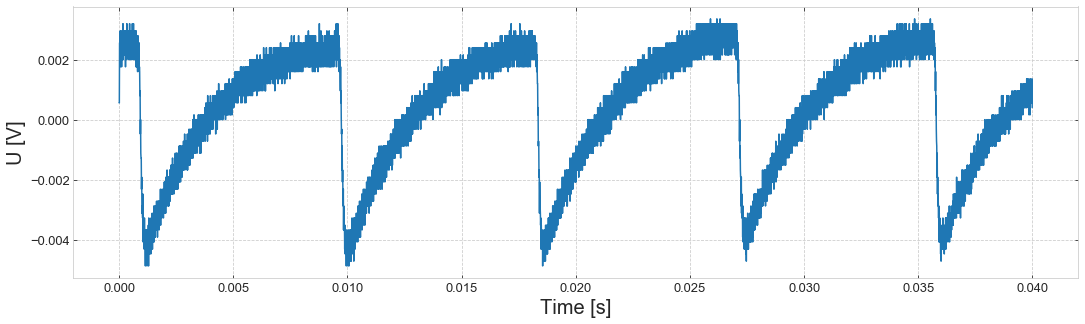

In [208]:
fig, axes = plt.subplots(figsize=(18,5))

axislabelsize = 20
axisticksize = 13

axes.plot(time, values)

axes.set_xlabel('Time [s]', fontsize=axislabelsize)
axes.set_ylabel('U [V]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.show()

### Fourier space

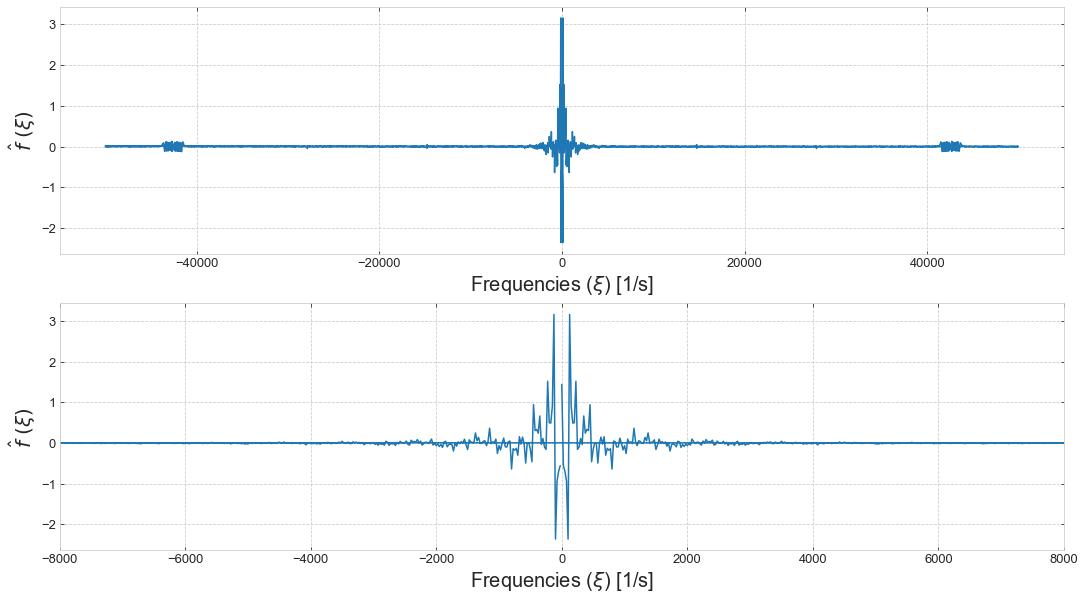

In [227]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols,5*nrows))

axislabelsize = 20
axisticksize = 13

# Calculate FFT and corresponding frequencies
# Sampling should be somewhere around 44 kHz
fourier = np.fft.fft(values)
freq = np.fft.fftfreq(values.size, d=float(header['Sampling Period']))

for i in range(nrows):
    axes[i].plot(freq, fourier.real)
    
    axes[i].set_xlabel(r'Frequencies ($\xi$) [1/s]', fontsize=axislabelsize)
    axes[i].set_ylabel(r'$\hat{f}\ (\xi)$', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)

freq_lim = 8000
axes[1].set_xlim(-freq_lim, freq_lim)
    
plt.show()

### Convolution of T and U

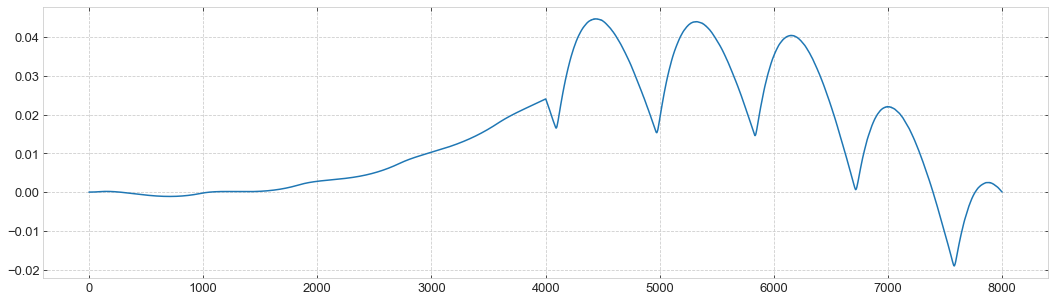

In [210]:
fig, axes = plt.subplots(figsize=(18,5))

axisticksize = 13

axes.plot(np.convolve(time, values))

axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.show()

### LP Butterworth

- https://dsp.stackexchange.com/questions/49460/apply-low-pass-butterworth-filter-in-python

In [211]:
# Sampling frequency
fs = 1/float(header['Sampling Period'])
# Cut-off frequency of the filter
fc = 1000
# Normalize the frequency
w = fc / (fs / 2)
# Butterworth filter
b, a = signal.butter(5, w, 'low')
output = signal.filtfilt(b, a, values)

C:\Users\Lordpb\AppData\Roaming\Python\Python36\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


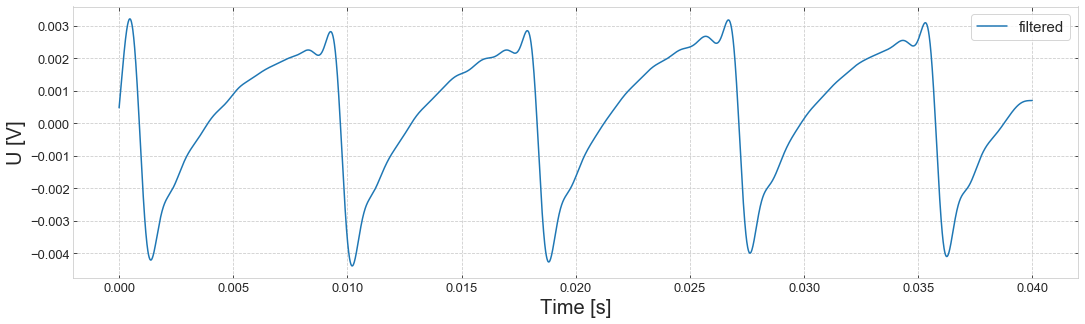

In [212]:
fig, axes = plt.subplots(figsize=(18,5))

axislabelsize = 20
axisticksize = 13
legendize = 15

axes.plot(time, output, label='filtered')

axes.set_xlabel('Time [s]', fontsize=axislabelsize)
axes.set_ylabel('U [V]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.legend(loc='upper right', fontsize=legendsize)
plt.show()

### Fourier space - Low pass filter

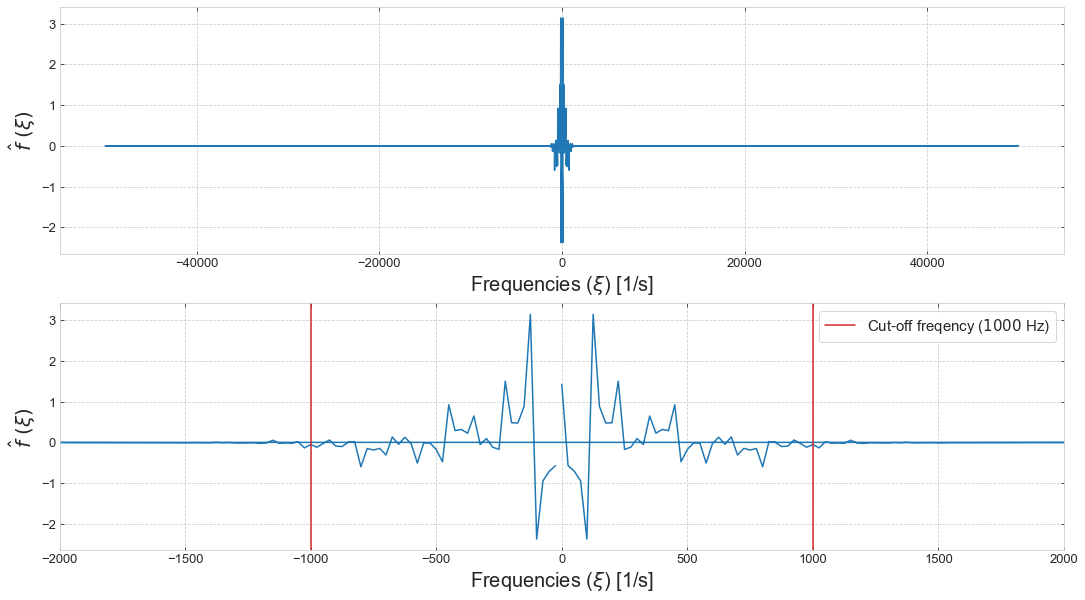

In [228]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols,5*nrows))

axislabelsize = 20
axisticksize = 13
legendsize = 15

# Calculate FFT and corresponding frequencies
# Sampling should be somewhere around 44 kHz
fourier = np.fft.fft(output)
freq = np.fft.fftfreq(output.size, d=float(header['Sampling Period']))

for i in range(nrows):
    axes[i].plot(freq, fourier.real)
    
    axes[i].set_xlabel(r'Frequencies ($\xi$) [1/s]', fontsize=axislabelsize)
    axes[i].set_ylabel(r'$\hat{f}\ (\xi)$', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)

freq_lim = 2*fc
axes[1].set_xlim(-freq_lim, freq_lim)

# Draw frequency cutoffs
axes[1].axvline(x=-fc, color='tab:red', label='Cut-off freqency (${0}$ Hz)'.format(fc))
axes[1].axvline(x=fc, color='tab:red')
    
plt.legend(loc='upper right', fontsize=legendsize)
plt.show()

## 2) Sliced signal

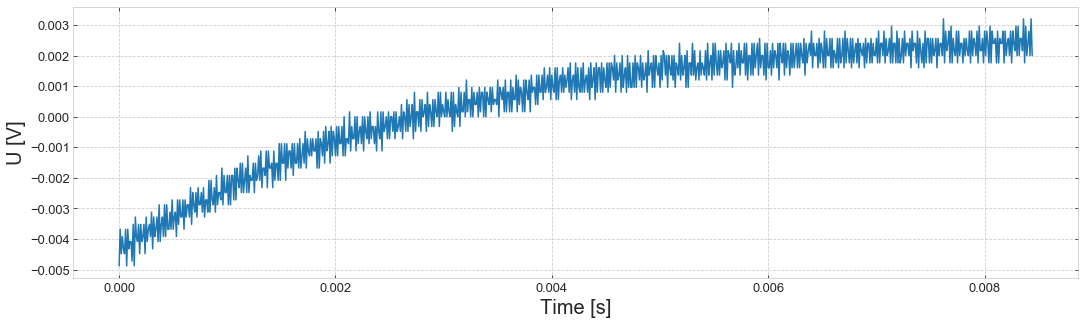

In [214]:
fig, axes = plt.subplots(figsize=(18,5))

axislabelsize = 20
axisticksize = 13

lower = 115
upper = 960
time_var = np.array(time[lower:upper])
time_var -= np.min(time_var)
values_var = np.array(values[lower:upper])

axes.plot(time_var, values_var)

axes.set_xlabel('Time [s]', fontsize=axislabelsize)
axes.set_ylabel('U [V]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.show()

### Fourier space

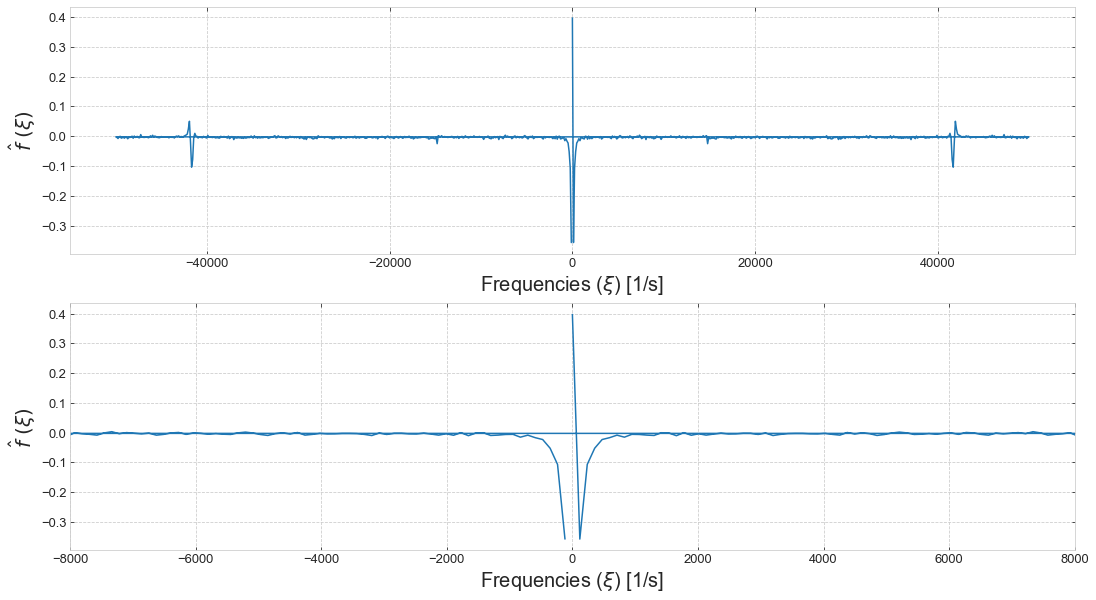

In [229]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols,5*nrows))

axislabelsize = 20
axisticksize = 13

# Calculate FFT and corresponding frequencies
# Sampling should be somewhere around 44 kHz
fourier_var = np.fft.fft(values_var)
freq_var = np.fft.fftfreq(values_var.size, d=float(header['Sampling Period']))

for i in range(nrows):
    axes[i].plot(freq_var, fourier_var.real)
    
    axes[i].set_xlabel(r'Frequencies ($\xi$) [1/s]', fontsize=axislabelsize)
    axes[i].set_ylabel(r'$\hat{f}\ (\xi)$', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)

freq_lim = 8000
axes[1].set_xlim(-freq_lim, freq_lim)
    
plt.show()

### LP Butterworth

- https://dsp.stackexchange.com/questions/49460/apply-low-pass-butterworth-filter-in-python

In [216]:
# Sampling frequency
fs = 1/float(header['Sampling Period'])
# Cut-off frequency of the filter
fc_var = 5000
# Normalize the frequency
w_var = fc_var / (fs / 2)
# Butterworth filter
b_var, a_var = signal.butter(5, w_var, 'low')
output_var = signal.filtfilt(b_var, a_var, values_var)

C:\Users\Lordpb\AppData\Roaming\Python\Python36\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


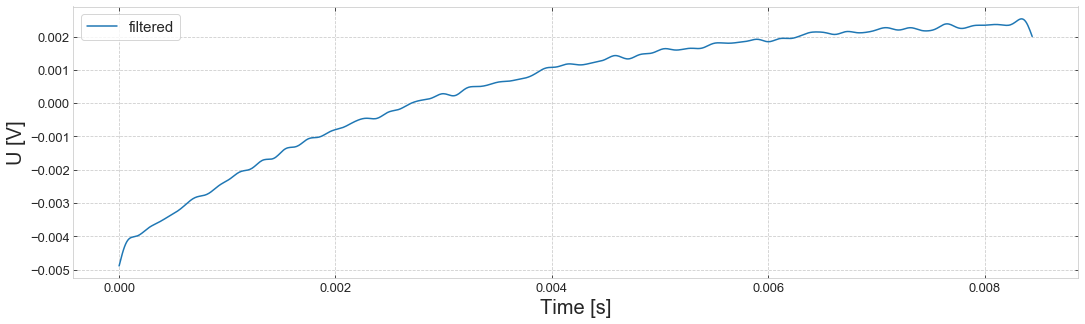

In [217]:
fig, axes = plt.subplots(figsize=(18,5))

axislabelsize = 20
axisticksize = 13
legendize = 15

axes.plot(time_var, output_var, label='filtered')

axes.set_xlabel('Time [s]', fontsize=axislabelsize)
axes.set_ylabel('U [V]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.legend(loc='upper left', fontsize=legendsize)
plt.show()

### Fourier space - Low pass filter

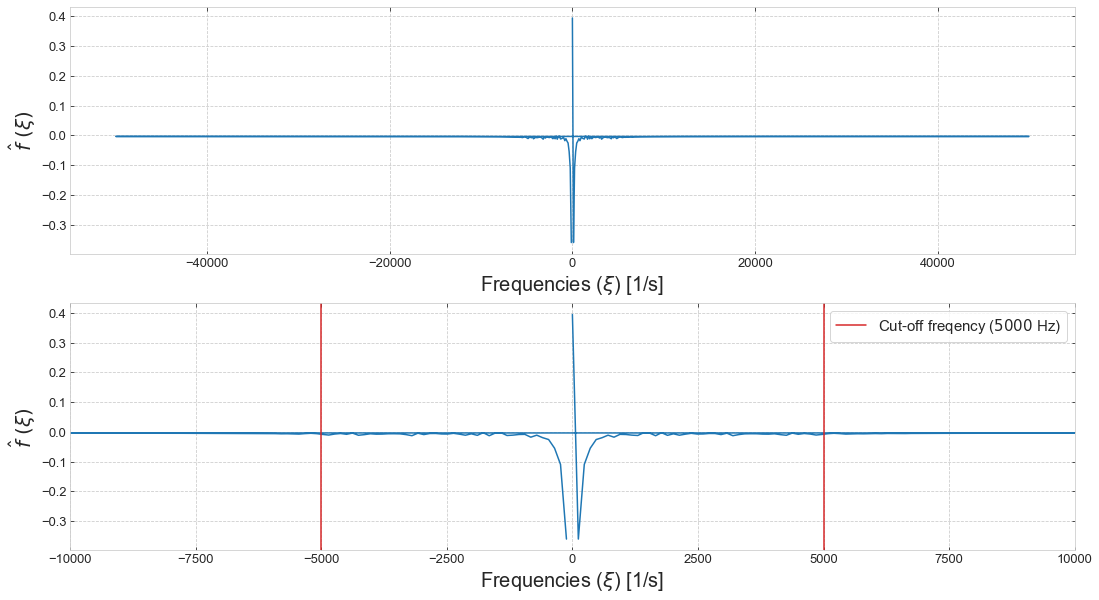

In [230]:
nrows = 2
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18*ncols,5*nrows))

axislabelsize = 20
axisticksize = 13
legendsize = 15

# Calculate FFT and corresponding frequencies
# Sampling should be somewhere around 44 kHz
fourier = np.fft.fft(output_var)
freq = np.fft.fftfreq(output_var.size, d=float(header['Sampling Period']))

for i in range(nrows):
    axes[i].plot(freq, fourier.real)
    
    axes[i].set_xlabel(r'Frequencies ($\xi$) [1/s]', fontsize=axislabelsize)
    axes[i].set_ylabel(r'$\hat{f}\ (\xi)$', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)

freq_lim = 2*fc_var
axes[1].set_xlim(-freq_lim, freq_lim)

# Draw frequency cutoffs
axes[1].axvline(x=-fc_var, color='tab:red', label='Cut-off freqency (${0}$ Hz)'.format(fc_var))
axes[1].axvline(x=fc_var, color='tab:red')
    
plt.legend(loc='upper right', fontsize=legendsize)
plt.show()

## Fit exponential

In [134]:
def fit_func(t, A, B, C):
    #return A + B * np.e ** (C * t + offset)
    return A + B * np.e ** (C * t)

In [135]:
def value_prep(time, values, prep=10, offset=0):
    """
    Prepares initial values for fitting exponential on input data
    with `scipy.curve_fit()`.

    Parameters
    ----------
    time : array, shape = [n_samples]
        Array of time values. Length should be identical to the values'
        array.
    values : array, shape = [n_samples]
        Array of measured values. Length should be identical to the time
        values' array.
    prep : int, initial value ``prep = 10``
        Sets the windows size for calculating the mean of short
        intervals to determine fitting coefficients.
    offset : int, optional
        Doesn't matter now.

    Returns
    -------
    A, B, C : floats
        Initial coefficients for scipy exponential fit.
    """
    # t = inf: exp(C * t(inf) + offset) = 0
    A = values[-prep:].mean()

    # t = 0: exp(C * t(0) + offset) = 1
    B = values[:prep].mean() - A

    # t = general solution:
    # y = A + B * np.e ** (C * t + offset)
    # C = ln((y - A) / B) / t
    dt = len(values) // 2
    C = np.log((values[dt:dt + prep].mean() - A) / B) / time[dt:dt+prep].mean()
    
    return A, B, C

### 1) Cut only

In [136]:
p0 = value_prep(time=time_var, values=values_var, prep=10, offset=0)
popt, pcov = curve_fit(fit_func, time_var, values_var, p0=p0)
perr = np.sqrt(np.diag(pcov))

print(b1 + 'Final equation' + b0 + ' : U(t) = {0} + {1} * e^({2} * t)'.format(p0[0], p0[1], p0[2]))
print(b1 + 'Characteristic time' + b0 + ' : {0} s'.format((-1/p0[2])/1000))

Final equation : U(t) = 0.002448 + -0.00668 * e^(-390.3485795601148 * t)
Characteristic time : 2.5618128318204813e-06 s


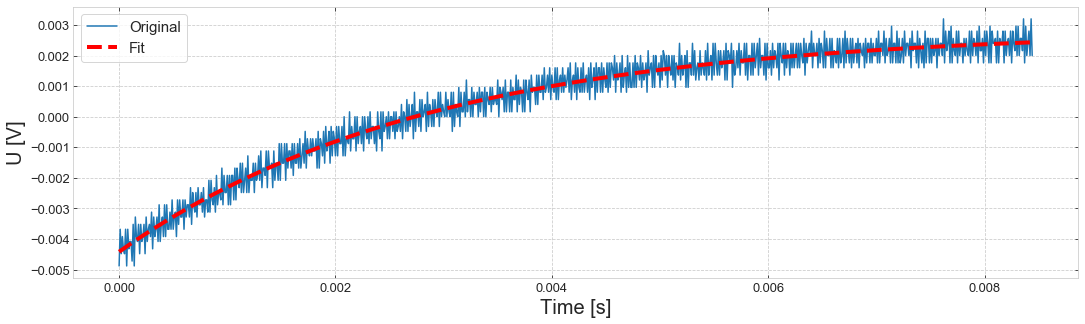

In [137]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,5))

axislabelsize = 20
axisticksize = 13

axes.plot(time_var, values_var, label='Original')
axes.plot(time_var, fit_func(time_var, *popt),
          c='red', linestyle='--', lw=4, label='Fit', zorder=2)

axes.set_xlabel('Time [s]', fontsize=axislabelsize)
axes.set_ylabel('U [V]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.legend(loc='upper left', fontsize=legendsize)
plt.show()

### 2) Cut + Low pass filter

In [138]:
p0 = value_prep(time=time_var, values=output_var, prep=10, offset=0)
popt, pcov = curve_fit(fit_func, time_var, output_var, p0=p0)
perr = np.sqrt(np.diag(pcov))

print(b1 + 'Final equation' + b0 + ' : U(t) = {0} + {1} * e^({2} * t)'.format(p0[0], p0[1], p0[2]))
print(b1 + 'Characteristic time' + b0 + ' : {0} s'.format((-1/p0[2])/1000))

Final equation : U(t) = 0.00243252337901712 + -0.006681789008855179 * e^(-390.42135840539856 * t)
Characteristic time : 2.561335281666733e-06 s


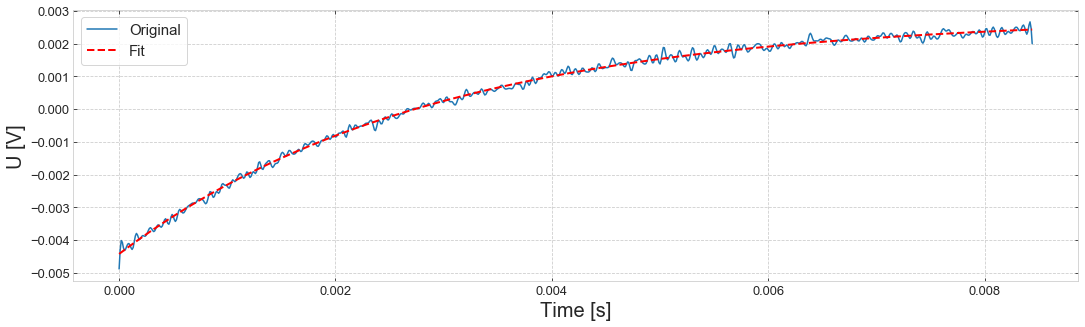

In [139]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,5))

axislabelsize = 20
axisticksize = 13
legendsize = 15

axes.plot(time_var, output_var, label='Original')
axes.plot(time_var, fit_func(time_var, *popt),
          c='red', linestyle='--', lw=2, label='Fit', zorder=2)

axes.set_xlabel('Time [s]', fontsize=axislabelsize)
axes.set_ylabel('U [V]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.legend(loc='upper left', fontsize=legendsize)
plt.show()